# Deep Learningモデルのアーキテクチャ比較
Driverless AIで利用可能な[事前学習モデル](https://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/expert_settings/image_settings.html#tensorflow-image-pretrained-models)の比較  
Experimentは、アーキテクチャの選択以外、デフォルト設定で実施。学習方法は転移学習（特徴量抽出器）  
データは75:25で、学習とテストに分割

***
### 実行方法

`(your_env) $ python speed_test.py DAI-URL DAI-User DAI-Password experiment_meta_data/Experiments_Params.csv`  
バックグラウンド実行の場合  
`(your_env) $ nohup python speed_test.py DAI-URL DAI-User DAI-Password experiment_meta_data/Experiments_Params.csv &`  
- dl_archtect_test上で実行
- dl_archtect_test上にresultフォルダを作成しておく（結果が"speedtest_XXXX年XX月XX日XX時XX分XX秒.json"で保存される）

***

In [61]:
import os
#import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [62]:
#!ls dl_archtect_test/result/

In [63]:
def get_resultdata(result_path) -> pd.DataFrame:
    all_files =  os.listdir(result_path)

    ## json fileのみ取得
    result_files = []
    for f in all_files:
        if os.path.splitext(f)[1] == '.json':
            result_files.append(f)

    print('All files: {}, json files: {}'.format(len(all_files), len(result_files)))

    ## 全てのjson fileを結合し、DataFrameとする
    for i, jf in enumerate(result_files):
        if i == 0:
            df = pd.read_json(os.path.join(result_path, jf), orient='index').transpose()
        else:
            df_tmp = pd.read_json(os.path.join(result_path, jf), orient='index').transpose()
            df = pd.concat([df, df_tmp])

    df = df.reset_index()
    print('Result data shape: {}'.format(df.shape))
    return df

***

## Car Dealsデータでの比較
車のPriceを車の特徴と写真から予測（回帰）。[Full Dataset](https://h2o-public-test-data.s3.amazonaws.com/bigdata/server/ImageData/car_deals.zip)  
実験では画像のみを特徴量に利用

In [64]:
df_train = pd.read_csv(os.path.join(os.environ['HOME'], 'Documents/Sample_Data/car_deals/sample/data.csv'))
df_train.shape

(34571, 16)

In [65]:
df_train.head(3)   # 画像データのみ（image_id）特徴量に利用

,image_id,Manufacturer,Model,Year,Category,Mileage,FuelType,EngineVolume,DriveWheels,GearBox,Doors,Wheel,Color,InteriorColor,LeatherInterior,Price
0,images/0.jpg,BMW,M6,2014,Coupe,33500.0,Petrol,4.4,Rear,Tiptronic,4/5,Left wheel,White,Black,True,39000
1,images/1.jpg,MERCEDES-BENZ,GLA 250,2015,Sedan,43000.0,Petrol,2.0,4x4,Tiptronic,4/5,Left wheel,Red,Black,True,10900
2,images/2.jpg,KIA,Forte,2014,Sedan,83000.0,Petrol,2.0,Front,Automatic,4/5,Left wheel,Black,Black,False,4500


#### ターゲット変数の分布

In [66]:
df_train['Price'].describe()

count    34571.000000
mean      6936.277921
std       6738.328308
min       1000.000000
25%       3000.000000
50%       5100.000000
75%       8325.000000
max      99500.000000
Name: Price, dtype: float64

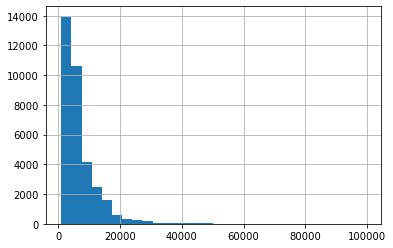

In [67]:
df_train['Price'].hist(bins=30)
plt.show()

#### サンプルの画像

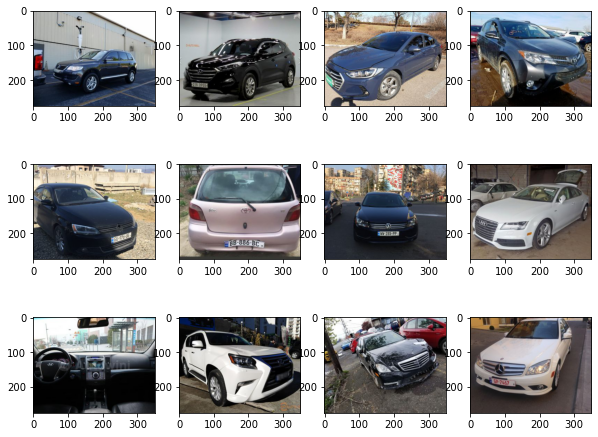

In [68]:
imgs = ['1143.jpg','16826.jpg','24237.jpg','36425.jpg','62171.jpg','77710.jpg',
        '87406.jpg','13124.jpg','23911.jpg','3182.jpg','50771.jpg','69760.jpg']

plt.figure(figsize=(10,8))
for i,img in enumerate(imgs):
    image_path_list = os.path.join(os.environ['HOME'], 'Documents/Sample_Data/car_deals/sample/images/', img)
    plt.subplot(3,4,i+1)
    plt.imshow(mpimg.imread(image_path_list), cmap="gray")

***
### 結果

In [69]:
df_car = get_resultdata('dl_archtect_test/result/')
df_car = df_car[df_car['Data_Name']=='car_deals.zip'].reset_index(drop=True)
df_car.head(3)

All files: 22, json files: 20
Result data shape: (20, 13)


,index,Data_Name,Try,Datasize_mb,N_Observation,N_features,Shape_Train,Shape_Test,Network,Duration_min,Experiment_Size_mb,Acc_Time_Interpret,Metrics
0,0,car_deals.zip,1,749.219669,34571,1,"[25928, 16]","[8643, 16]",densenet121,54.72271,1538.862349,"[7, 2, 8]","{'scorer': 'RMSE', 'val_score': 5650.540527343..."
1,0,car_deals.zip,1,749.219669,34571,1,"[25928, 16]","[8643, 16]",xception,39.420772,2222.24338,"[7, 2, 8]","{'scorer': 'RMSE', 'val_score': 5710.359375, '..."
2,0,car_deals.zip,1,749.219669,34571,1,"[25928, 16]","[8643, 16]",seresnext50,88.177787,2481.342455,"[7, 2, 8]","{'scorer': 'RMSE', 'val_score': 5673.998535156..."


In [70]:
val_score_lst = []
test_score_lst = []
for _, row in df_car.iterrows():
    #print(row['Metrics'])
    val_score_lst.append(row['Metrics']['val_score'])
    test_score_lst.append(row['Metrics']['test_score'])

df_car['val_score_RMSE'] = val_score_lst
df_car['test_score_RMSE'] = test_score_lst

In [71]:
df_car[['Network','Duration_min','Experiment_Size_mb','val_score_RMSE','test_score_RMSE']]

,Network,Duration_min,Experiment_Size_mb,val_score_RMSE,test_score_RMSE
0,densenet121,54.72271,1538.862349,5650.540527,5129.828613
1,xception,39.420772,2222.24338,5710.359375,5170.921387
2,seresnext50,88.177787,2481.342455,5673.998535,5104.689453
3,resnet34,38.185259,2239.956187,5761.494141,5181.739258
4,efficientnetb2,38.534034,1516.891189,5615.804688,5048.395996
5,efficientnetb0,44.510599,1324.197435,5641.707031,5036.506348
6,inception_v3,46.859148,1801.549356,5804.635254,5209.624023
7,resnet50,46.332429,1859.999482,5625.353027,5149.396484
8,seresnet50,44.91441,2519.726963,5552.256348,5114.483887
9,mobilenetv2,39.210557,1239.15507,5767.181152,5200.565430


### 学習時間とサイズ

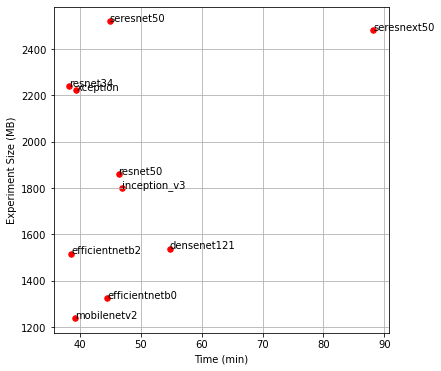

In [72]:
plt.figure(figsize=(6,6))
plt.scatter(df_car['Duration_min'], df_car['Experiment_Size_mb'], s=30, color="red")
plt.xlabel("Time (min)")
plt.ylabel("Experiment Size (MB)")
for i, label in enumerate(df_car['Network']):
    plt.annotate(label, (df_car['Duration_min'][i], df_car['Experiment_Size_mb'][i]))
plt.grid(True)

plt.show()

### 精度比較

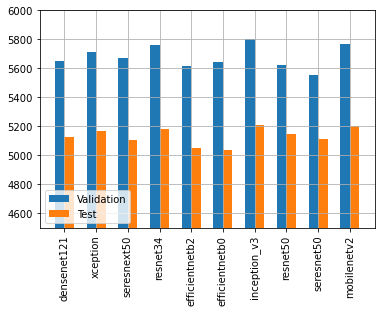

In [73]:
plt.bar(df_car['Network'], df_car['val_score_RMSE'], align="edge", width=-0.3, label='Validation')
plt.bar(df_car['Network'], df_car['test_score_RMSE'], align="edge", width= 0.3, label='Test')
plt.xticks(rotation=90)
plt.legend(loc=3)
plt.grid(True)
plt.ylim(4500, 6000)

plt.show()

***

## pathology（病理組織診断）データでの比較
病理組織画像から疾病の有無を予測（分類）。[Full Dataset](https://h2o-public-test-data.s3.amazonaws.com/bigdata/server/ImageData/histopathology_train.zip)  
画像とターゲットのみのデータ

In [74]:
df_train = pd.read_csv(os.path.join(os.environ['HOME'], 'Documents/Sample_Data/histopathology/sample/labels.csv'))
df_train.shape

(20000, 2)

#### ターゲット変数の分布

In [75]:
df_train['label'].value_counts(), df_train['label'].value_counts(normalize=True)

(0    11803
 1     8197
 Name: label, dtype: int64,
 0    0.59015
 1    0.40985
 Name: label, dtype: float64)

#### サンプルの画像

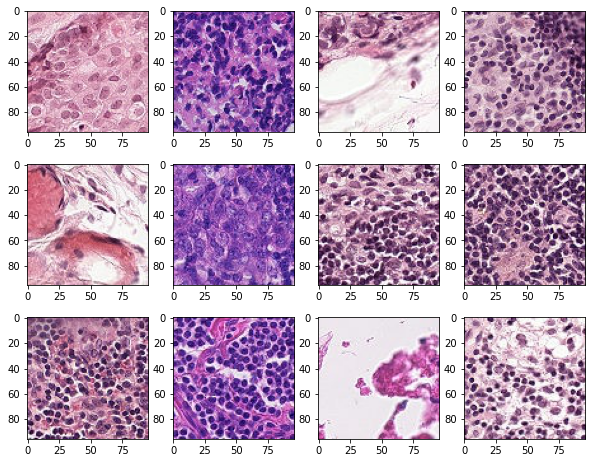

In [76]:
imgs = ['0a08ccabc88a5870c70468a9536d45f0a6c702b2.tif','0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif',
        '0a1c1c161842805e5582a4a86a43b475b9d314a3.tif','0a1e7e52d6cde04413fa931e76607b2437ae9c86.tif',
        '0a29fd14d6f84f9c0e642c0d880a375d9864e57f.tif','0a2a844bfcabacb0cc00a7ab544b7d3230912acc.tif',
        '0a35acf0f4d317b34815db2c50196efd1c7dde1b.tif','0a3a7f1f02ae93de6f13ba5ff6ff9c06ca1c5b25.tif',
        '0a3b7294b63b7f62c1b30d8440c1c7b2a7845a81.tif','0a3e311028fac8297dc11605b499e7bad4ed72f3.tif',
        '0a40b2414f677a5e6ac8ced124c1111b1028f753.tif','0a4a78bb9695a03fa1f04cb09659f2539883125c.tif']

plt.figure(figsize=(10,8))
for i,img in enumerate(imgs):
    image_path_list = os.path.join(os.environ['HOME'], 'Documents/Sample_Data/histopathology/sample/images/', img)
    plt.subplot(3,4,i+1)
    plt.imshow(mpimg.imread(image_path_list), cmap="gray")

***
### 結果

In [77]:
df_ph = get_resultdata('dl_archtect_test/result/')
df_ph = df_ph[df_ph['Data_Name']=='histopathology_train.zip'].reset_index(drop=True)
df_ph.head(3)

All files: 22, json files: 20
Result data shape: (20, 13)


,index,Data_Name,Try,Datasize_mb,N_Observation,N_features,Shape_Train,Shape_Test,Network,Duration_min,Experiment_Size_mb,Acc_Time_Interpret,Metrics
0,0,histopathology_train.zip,1,535.888886,20000,1,"[15000, 2]","[5000, 2]",densenet121,31.884246,1488.211802,"[7, 2, 8]","{'scorer': 'AUC', 'val_score': 0.9229875171198..."
1,0,histopathology_train.zip,1,535.888886,20000,1,"[15000, 2]","[5000, 2]",resnet50,33.715807,2364.457278,"[7, 2, 8]","{'scorer': 'AUC', 'val_score': 0.9301732537883..."
2,0,histopathology_train.zip,1,535.888886,20000,1,"[15000, 2]","[5000, 2]",resnet34,25.742817,2217.126509,"[7, 2, 8]","{'scorer': 'AUC', 'val_score': 0.9132089946178..."


In [78]:
val_score_lst = []
test_score_lst = []
for _, row in df_ph.iterrows():
    #print(row['Metrics'])
    val_score_lst.append(row['Metrics']['val_score'])
    test_score_lst.append(row['Metrics']['test_score'])

df_ph['val_score_AUC'] = val_score_lst
df_ph['test_score_AUC'] = test_score_lst

In [79]:
df_ph[['Network','Duration_min','Experiment_Size_mb','val_score_AUC','test_score_AUC']]

,Network,Duration_min,Experiment_Size_mb,val_score_AUC,test_score_AUC
0,densenet121,31.884246,1488.211802,0.922988,0.921715
1,resnet50,33.715807,2364.457278,0.930173,0.930235
2,resnet34,25.742817,2217.126509,0.913209,0.914604
3,mobilenetv2,28.811057,1230.52513,0.908223,0.911149
4,xception,34.011497,2200.152316,0.913332,0.913599
5,seresnext50,56.482373,2478.537783,0.923756,0.925760
6,inception_v3,33.487953,2271.981292,0.915847,0.912776
7,efficientnetb2,35.010646,1528.115597,0.918036,0.923386
8,efficientnetb0,31.205813,1329.725394,0.912845,0.912242
9,seresnet50,26.948848,2478.652963,0.926710,0.931055


### 学習時間とサイズ

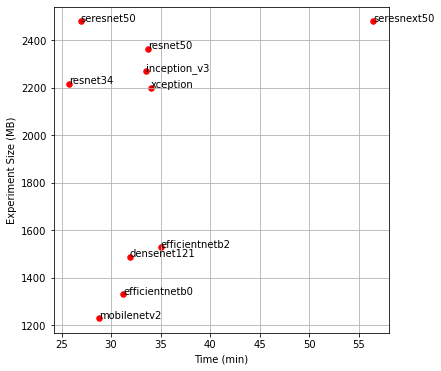

In [80]:
plt.figure(figsize=(6,6))
plt.scatter(df_ph['Duration_min'], df_ph['Experiment_Size_mb'], s=30, color="red")
plt.xlabel("Time (min)")
plt.ylabel("Experiment Size (MB)")
for i, label in enumerate(df_ph['Network']):
    plt.annotate(label, (df_ph['Duration_min'][i], df_ph['Experiment_Size_mb'][i]))
plt.grid(True)

plt.show()

### 精度比較

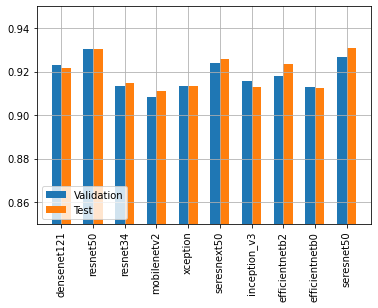

In [81]:
plt.bar(df_ph['Network'], df_ph['val_score_AUC'], align="edge", width=-0.3, label='Validation')
plt.bar(df_ph['Network'], df_ph['test_score_AUC'], align="edge", width= 0.3, label='Test')
plt.xticks(rotation=90)
plt.legend(loc=3)
plt.grid(True)
plt.ylim(0.85, 0.95)

plt.show()